In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Inference

```{margin}
These sections continue to draw on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

One of the most classic applications of frequentist stastistics is the comparison of two groups to see if there is a difference in their means. We previously looked at this using both z-tests and t-tests.

But how is this done in the Bayesian setting?

## The Bayesian Approach

A Bayesian alternative is to compute the posterior distribution of the difference between the groups. 

Then we can use that distribution to answer whatever questions we are interested in, including:
  - the most likely size of the difference
  - a credible interval that’s likely to contain the true difference
  - the probability of superiority
  - the probability that the difference exceeds some threshold.

```{margin} 
Image credit: DALLE, prompt: "23 third graders in a scientific study"
```

## Example: Improving Reading Ability

To demonstrate this process, we'll solve a problem about evaluating the effect of an educational “treatment” compared to a control.

<center>
    
<img src="images/DALLE-23-third-graders-in-a-scientific-study.png" width="600px">
    
</center>


```{margin} 
Data is from "The effects of an elaborated directed reading activity on the metacomprehension skills of third graders," a Ph.D. dissertation in educational psychology written in 1987, which was used as an example in Introduction to the Practice of Statistics by David S. Moore and George P. McCabe, and then published on DASL, a web page that collects data stories.
```

### What's the data? 

>An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

In [3]:
df = pd.read_csv('images/drp_scores.csv')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


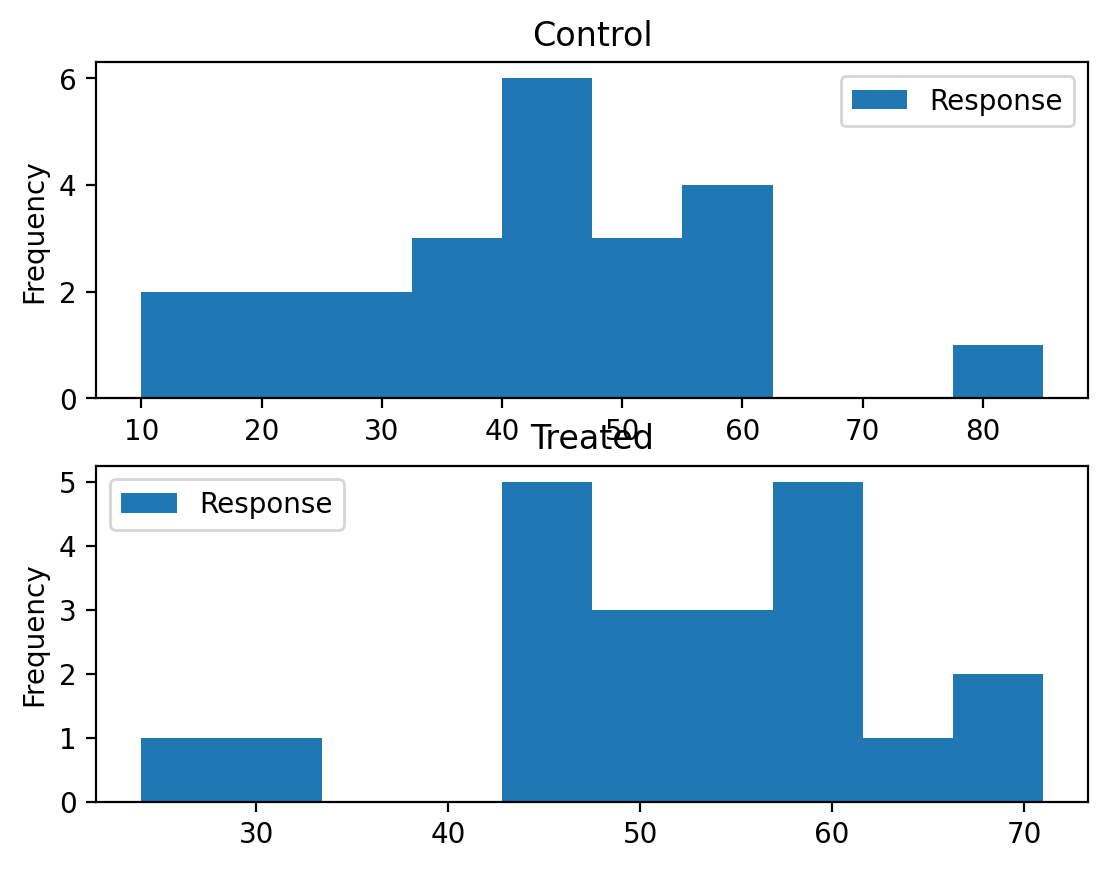

In [4]:
ax = plt.subplot(2, 1, 1)
df[df.Treatment == 'Control'].plot(ax=ax, kind = 'hist', title="Control");
ax = plt.subplot(2, 1, 2)
df[df.Treatment == 'Treated'].plot(ax=ax, kind = 'hist', title="Treated");

### Approaching the problem

We'll assume that for the entire population of students the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation. 

We’ll use $\mu$ and $\sigma$ to denote these unknown parameters

And we’ll do a Bayesian update to estimate what they are.

To put it another way, we'll use a Bayesian update to **estimate paramaters** for normal distributions that fit our data.

### The Prior

First we need a prior distribution for the parameters. Since there are two parameters, it will be a joint distribution. 

We'll assume that the prior distributions for $\mu$ and $\sigma$ are uniform:

In [5]:
from scipy.stats import randint

# uniform prior for mu
prior_mu  = pd.DataFrame(index = np.linspace(20, 80, num=101))
prior_mu ['probs'] = 1/101

#uniform prior for sigma
prior_sigma  = pd.DataFrame(index = np.linspace(5, 30, num=101))
prior_sigma ['probs'] = 1/101

And we'll want to consider the joint distribtion of the two paramaters:

In [6]:
# multiplies prbabilities from two distributions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1['probs'], pmf2['probs'])
    return pd.DataFrame(X * Y, columns=pmf1.index, index=pmf2.index)

prior = make_joint(prior_mu, prior_sigma)

### The Likelihood

We would like to know the probability of each score in the dataset for each hypothetical pair of values, $\mu$ and $\sigma$.

Put another way for each of our 101 possible $\mu$s and 101 possible $\sigma$s, we need to calculate the likelihood for each of our 44 students.

First let's create a data object just to store all that information:

In [7]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, df.Response)
mu_mesh.shape

(101, 101, 44)

Then let's calculate the probability of each score for each $\mu$ and $\sigma$:

In [8]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)

Finally, to get the actual likelihood of each $\mu$ and $\sigma$ we take the product across the data. We want likelihoods for the parameters for the control and treatment groups separately.

In [9]:
# control
likelihood_control = densities[:,:,df['Treatment']=="Control"].prod(axis=2)

# treated
likelihood_treated = densities[:,:,df['Treatment']=="Treated"].prod(axis=2)
likelihood_treated.shape

(101, 101)

### The Update

We'll create posterier distriburions foe control and treated the usual way:

In [10]:
# update with control likelihood
posterior_control = prior * likelihood_control
prob_data = posterior_control.to_numpy().sum()
posterior_control = posterior_control / prob_data

#update with treated likelihood
posterior_treated = prior * likelihood_treated
prob_data = posterior_treated.to_numpy().sum()
posterior_treated = posterior_treated / prob_data

What are these posterior distributions actually conveying? It helps to visualize the probabilities:

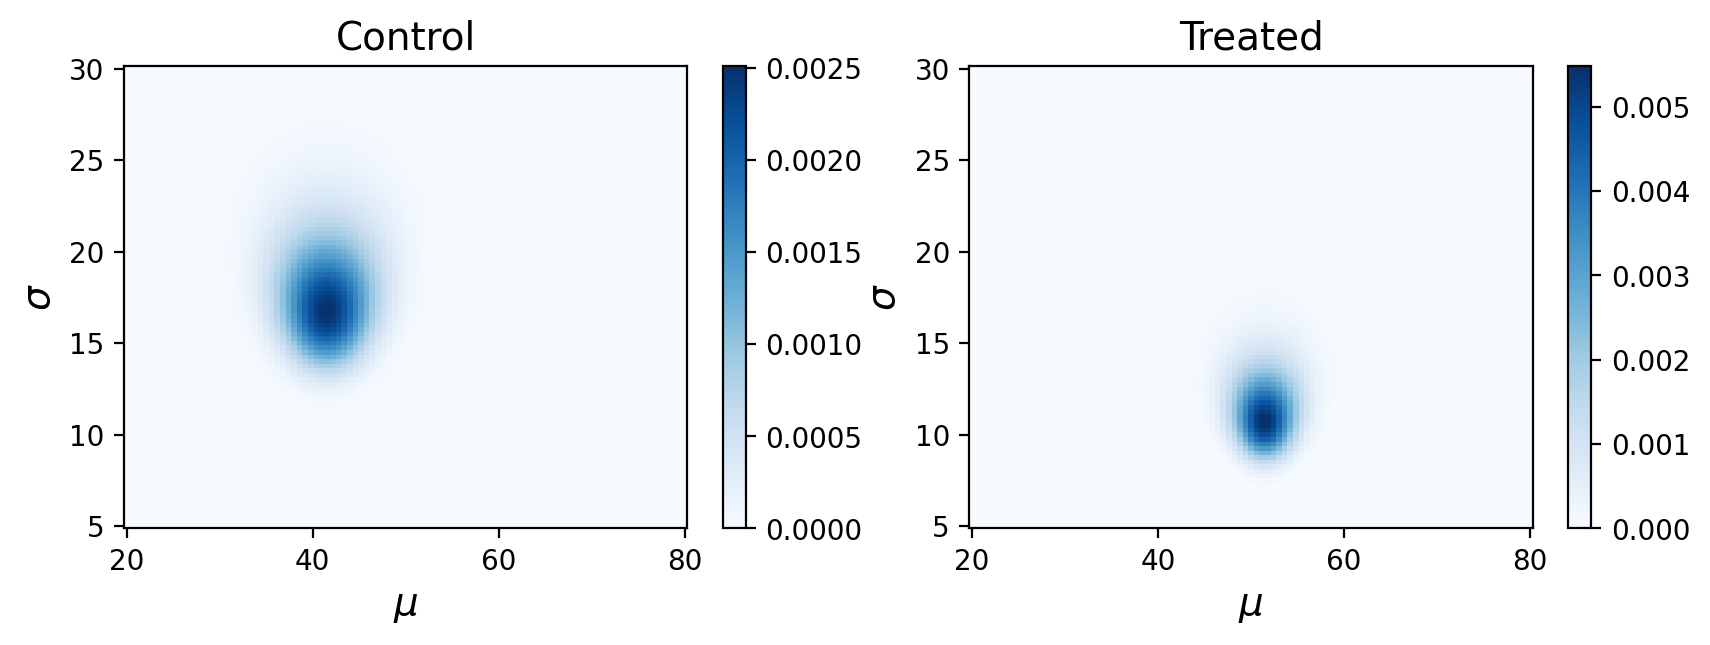

In [11]:
plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.pcolormesh(posterior_control.columns, posterior_control.index, posterior_control, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Control', size=14);

ax = plt.subplot(1, 2, 2)
plt.pcolormesh(posterior_treated.columns, posterior_treated.index, posterior_treated, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Treated', size=14);

Remember, this is showing the joint posterior probabilities for **parameters** that best describe our observed data.

### Posterior Marginal Distributions

Just like in our previous example of using a joint distribution to model the heights of two individuals, we'll look at  posterior marginal distributions, except this time for each paramater rather than each measurement.

In [19]:
marginal_mean_control = posterior_control.sum(axis=0)
marginal_mean_treated = posterior_treated.sum(axis=0)

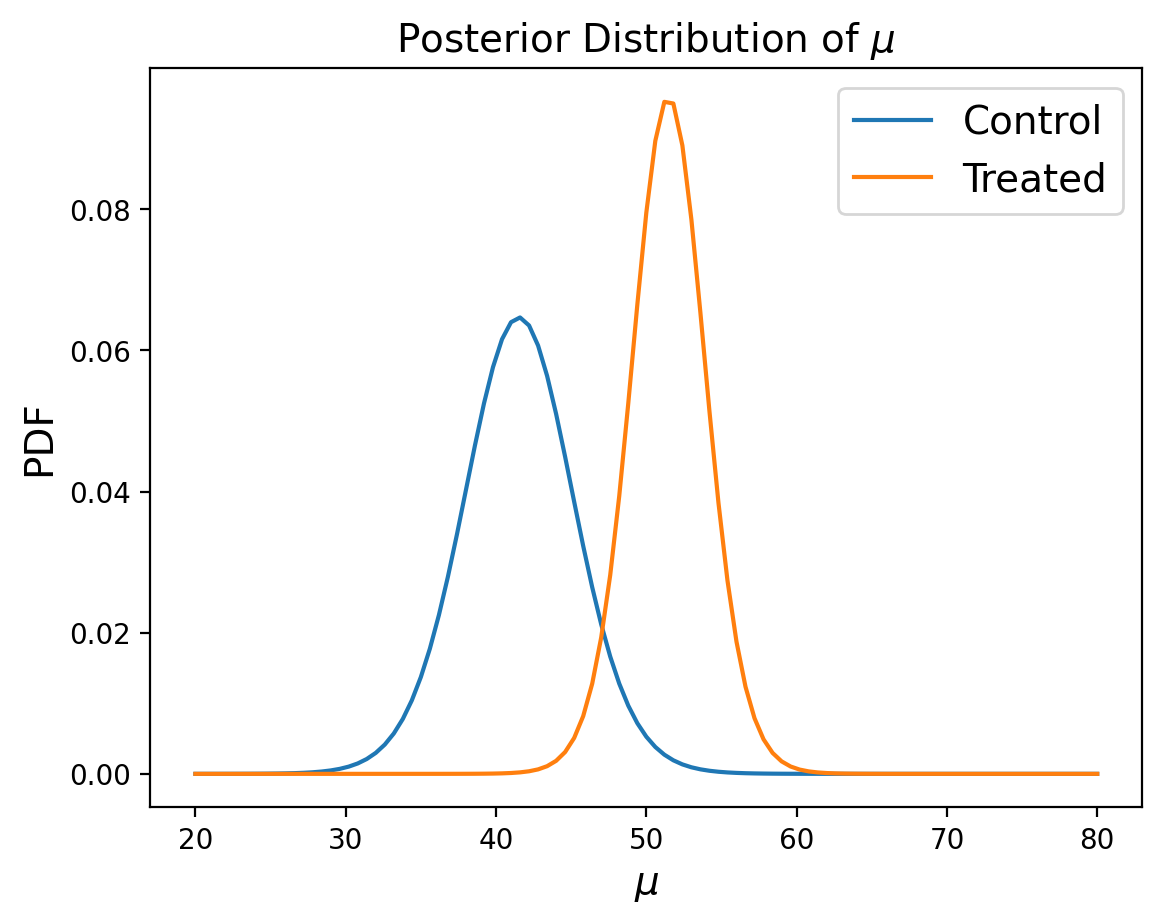

In [31]:
fig, ax = plt.subplots()
marginal_mean_control.plot(ax=ax)
marginal_mean_treated.plot(ax=ax)
ax.legend(['Control', 'Treated'], fontsize = 14, loc = 'best')
plt.title('Posterior Distribution of $\mu$', size=14)
plt.xlabel('$\mu$', size=14)
plt.ylabel('PDF', size=14);

We can then compare the marginals of the two groups using the probability of superiority:

In [18]:
def prob_of_s(dist1, dist2):
    """Compute the probability of superiority."""
    total = 0
    for i1 in dist1.index:
        for i2 in dist2.index:
            if i1 > i2:
                total += dist1[i1] * dist2[i2]
    return total

prob_of_s(marginal_mean_treated, marginal_mean_control)

0.9804790251873254

Let's compare that to a t-test, which would have been the frequentist approach given the small number of samples:

In [20]:
from scipy.stats import ttest_ind
ttest_ind(df.Response[df.Treatment=="Treated"],df.Response[df.Treatment=="Control"])

Ttest_indResult(statistic=2.266551599585943, pvalue=0.028629482832245753)

It's good to see that these probabilities generally agree with each other!

### Distribution of Differences

Now let's consider the difference in the two distributions:

In [87]:
def sub_dist(dist1, dist2):
    """Compute the distribution of a difference."""
    p_dist  = pd.DataFrame(index = np.unique(np.subtract.outer(dist1.index,dist2.index).flatten()))
    p_dist['probs'] = 0 
    for i1 in dist1.index:
        for i2 in dist2.index:
            q = i1 - i2
            p = dist1[i1] * dist2[i2]
            if q in p_dist.index:
                p_dist.probs[p_dist.index==q] = p_dist.probs[p_dist.index==q] + p
            else:
                p_dist.probs[p_dist.index==q] = p
    return p_dist

pmf_diff = sub_dist(marginal_mean_treated, marginal_mean_control)

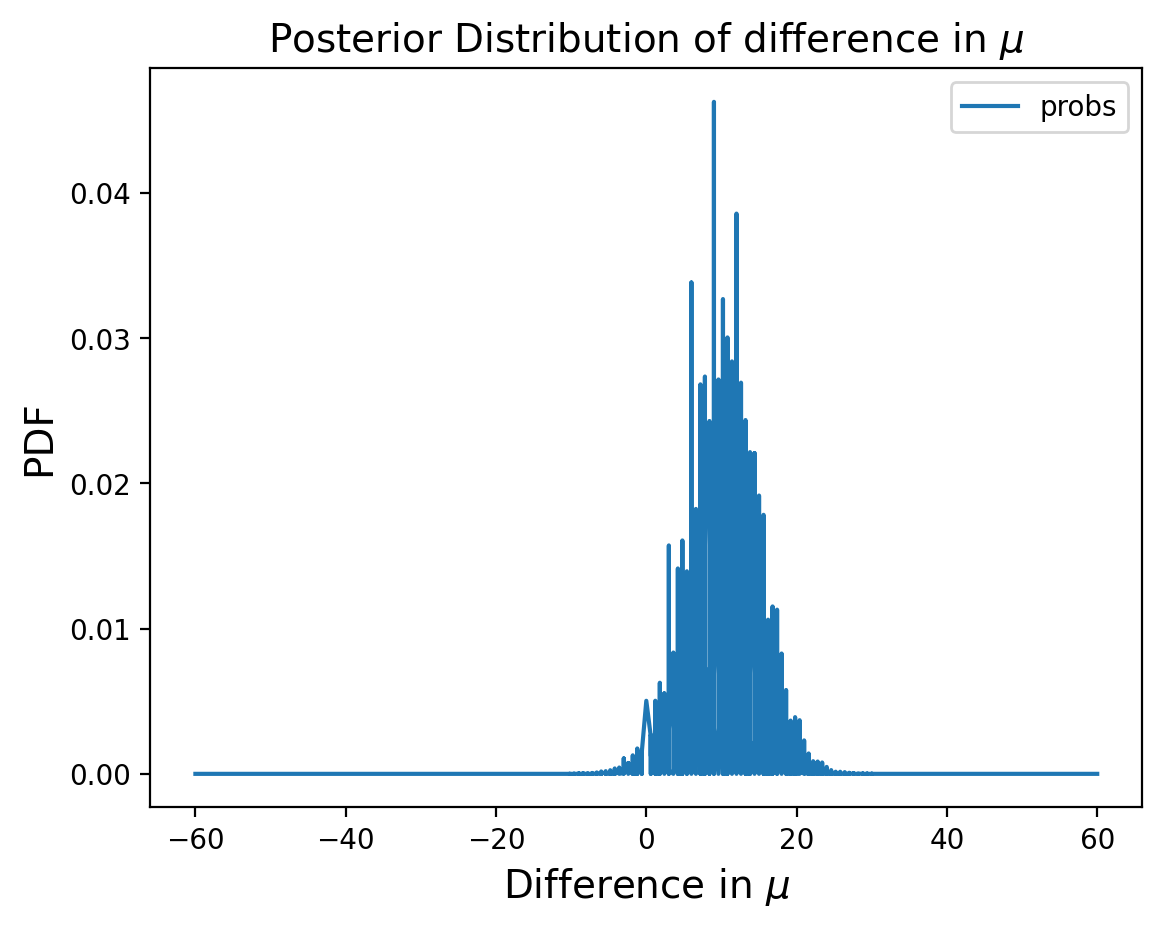

In [86]:
pmf_diff.plot()
plt.title('Posterior Distribution of difference in $\mu$', size=14)
plt.xlabel('Difference in $\mu$', size=14)
plt.ylabel('PDF', size=14);

Let's find the MMSE of the difference:

In [111]:
np.sum(pmf_diff.index * pmf_diff.probs)

9.954413088940848

And we can also calculate the probability that the difference is greater than some arbitrary value, lets say 5:

In [117]:
sum(pmf_diff.probs[pmf_diff.index>5])

0.8558784849055037

And the 90% credible interval:

In [118]:
[max(pmf_diff.index[np.cumsum(pmf_diff).probs < .05]), min(pmf_diff.index[np.cumsum(pmf_diff).probs > .95])]

[2.3999999999999915, 17.4]

So using the difference in posterior distributions of the means, we can learn everything we need to know about the difference in populations. 

However, you may have noticed that along the way we had to make some big matricies. For a large dataset this could become infeasible to calculate. There is a shortcut though!

## Using Summary Statistics

In our example so far we computed the likelihood of the entire dataset.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary. For example, if we compute the mean and standard deviation of the data, we can compute the likelihood of those summary statistics under each hypothesis.

So let's assume that our observed test scores are samples from a large distribution with mean $\mu$ and standard deviation $\sigma$. We can compute a mean *m* and a standard deviation *s* for any sampling from our distribtion of size *n*. 

We  know from our lesson on sampling that these means *m* are normally distributed with a mean of $\mu$ and a standard deviation of $\frac{\sigma}{\sqrt{n}}$

```{margin}
You can learn more about the sample variance distribution here: https://towardsdatascience.com/why-is-the-sample-variance-distributed-with-n-1-degrees-of-freedom-c9edcdada28b.
```

But what about the standard deviations *s*? They also have some sampling distribution they follow. It turns out this is actually much more complicated than the sampling distribution of means (and beyond the scope of this class). 

It is enough to know that $\frac{ns^2}{\sigma^2}$ follows a chi-squared distribution with $n-1$ degrees of freedom. We'll use that in our code.

These will allow us to calculate the likelihood of any observed mean and standard deviation for a single sampling of our data.

## Improving Reading Ability Revisited

So let's revisit our previous example using summary statistics.

### The Prior

The prior will be completely unchanged from before, a uniform prior for both $\mu$ and $\sigma$

In [121]:
from scipy.stats import randint

# uniform prior for mu
prior_mu  = pd.DataFrame(index = np.linspace(20, 80, num=101))
prior_mu ['probs'] = 1/101

#uniform prior for sigma
prior_sigma  = pd.DataFrame(index = np.linspace(5, 30, num=101))
prior_sigma ['probs'] = 1/101

# make joint probability
prior = make_joint(prior_mu, prior_sigma)

### The Likelihood

This time we'll use what we know about summary statistics to compute the likelihood for control and treated students.

In [127]:
# all mus and sigmas to calculate likelihoods with
mus, sigmas = np.meshgrid(prior.columns, prior.index)

# Control summary stats
n_control = len(df.Response[df.Treatment=="Control"])
m_control = df.Response[df.Treatment=="Control"].mean()
s_control = df.Response[df.Treatment=="Control"].std()

#the likelihood of a mean of a sample
likelihood_m_control = norm(mus, sigmas/np.sqrt(n_control)).pdf(m_control)

#the likelihood of standard deviation of a sample
from scipy.stats import chi2
t_control = n_control * s_control**2 / sigmas**2
likelihood_s_control = chi2(n_control-1).pdf(t_control)

# Treated summary stats
n_treated = len(df.Response[df.Treatment=="Treated"])
m_treated = df.Response[df.Treatment=="Treated"].mean()
s_treated = df.Response[df.Treatment=="Treated"].std()

#the likelihood of a mean of a sample
likelihood_m_treated = norm(mus, sigmas/np.sqrt(n_treated)).pdf(m_treated)

#the likelihood of standard deviation of a sample
t_treated = n_treated * s_treated**2 / sigmas**2
likelihood_s_treated = chi2(n_treated-1).pdf(t_treated)

### The Update

We can the apply the two likelihoods as separate updates to the prior:

```{margin}
According to Basu’s theorem, m and s are independent.
```

In [128]:
# control
posterior_control_summary = prior * likelihood_m_control * likelihood_s_control
prob_data = posterior_control_summary.to_numpy().sum()
posterior_control_summary = posterior_control_summary / prob_data

#treated
posterior_treated_summary = prior * likelihood_m_treated * likelihood_s_treated
prob_data = posterior_treated_summary.to_numpy().sum()
posterior_treated_summary = posterior_treated_summary / prob_data

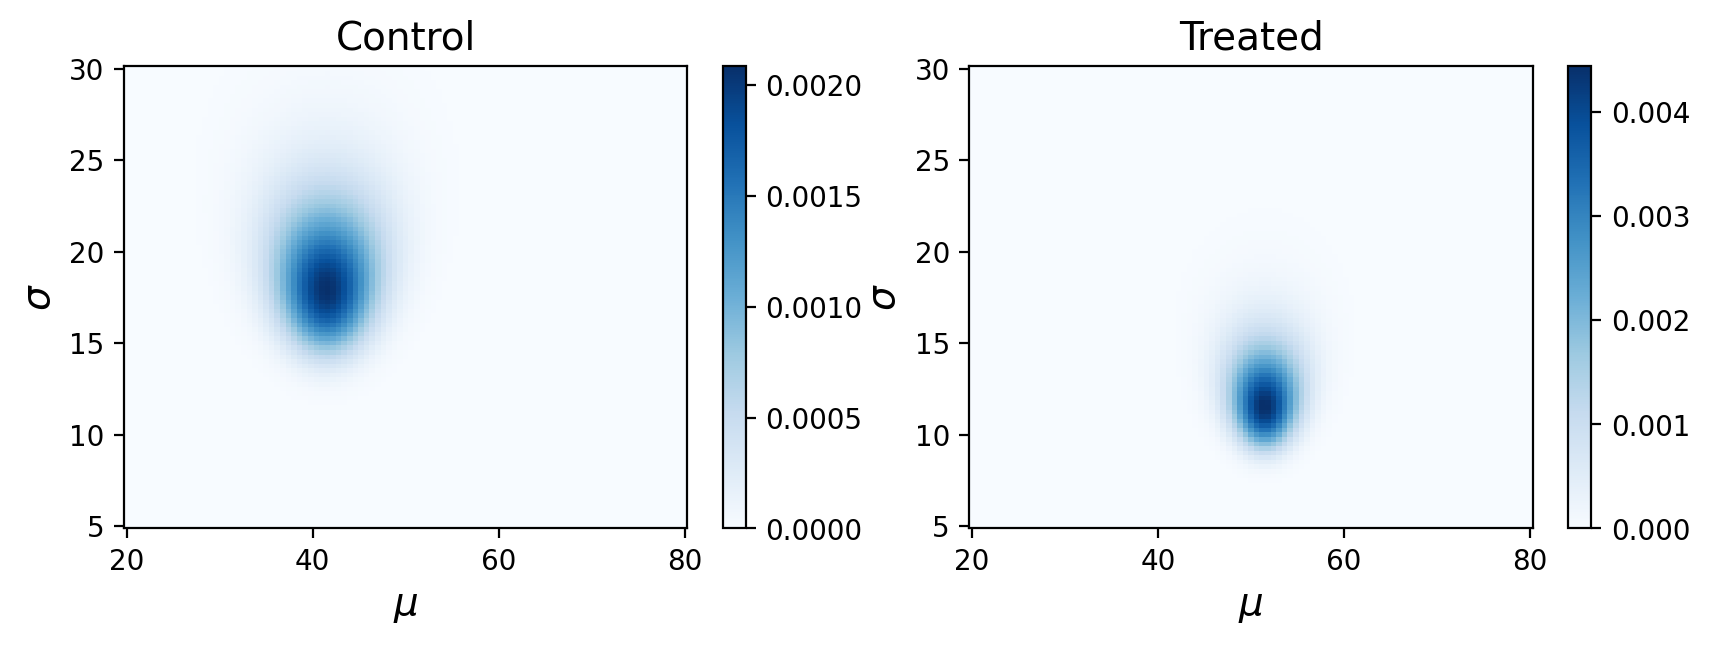

In [129]:
plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.pcolormesh(posterior_control_summary.columns, posterior_control_summary.index, posterior_control_summary, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Control', size=14);

ax = plt.subplot(1, 2, 2)
plt.pcolormesh(posterior_treated_summary.columns, posterior_treated_summary.index, posterior_treated_summary, cmap='Blues')
plt.colorbar()
plt.xlabel('$\mu$', size=14)
plt.ylabel('$\sigma$', size=14)
plt.title('Treated', size=14);

Looks like we have something pretty similar to before!

Let's compare the marginals to see how close we got using summary statistics:

In [131]:
marginal_mean_control_summary = posterior_control_summary.sum(axis=0)
marginal_mean_treated_summary = posterior_treated_summary.sum(axis=0)

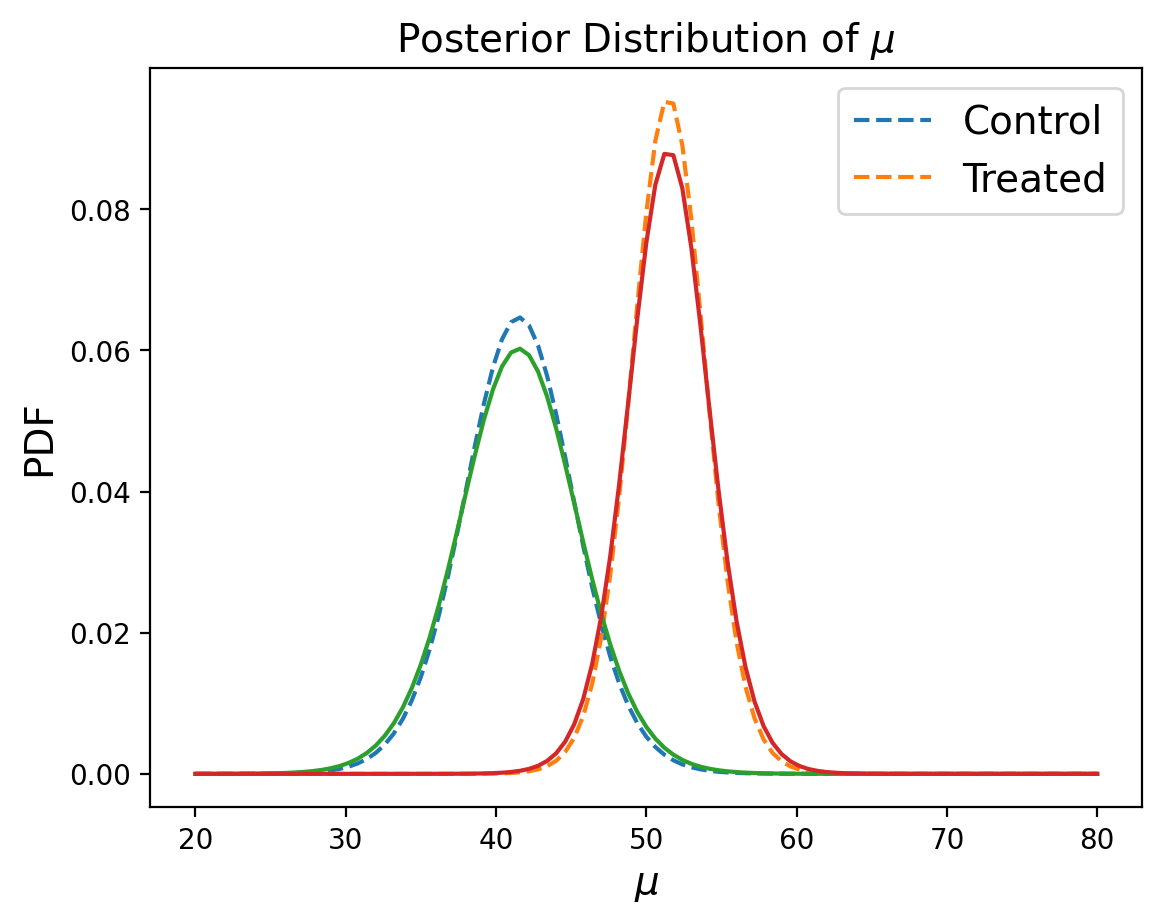

In [132]:
fig, ax = plt.subplots()
marginal_mean_control.plot(ax=ax, ls="--")
marginal_mean_treated.plot(ax=ax, ls="--")
marginal_mean_control_summary.plot(ax=ax)
marginal_mean_treated_summary.plot(ax=ax)
ax.legend(['Control', 'Treated'], fontsize = 14, loc = 'best')
plt.title('Posterior Distribution of $\mu$', size=14)
plt.xlabel('$\mu$', size=14)
plt.ylabel('PDF', size=14);

Looks pretty good!

## Summary

In this section we saw that we can use Baysian inference to estimate **parameters** that describe our data. We can then use this to look at differences between populations, something that is often thought of as the domain of frequentist statistics.

We then saw that we can borrow what we learned in frequenist statistics about sampling to make this process much more efficient.